In [1]:
using PyPlot

In [136]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (10^12 $ / C^2)
D_0 = β .* δT_0.^2; # baseline damages (10^12 $)
ρ = 0.02 # utility discount rate

GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 0.2*GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t); # carbon removal
ϕ[t.>2100] .= ϕ[t.==2100]
φ = nondim_linear(t)/3.; # emissions reductions
λ = nondim_linear(t)/8.; # adaptation
χ = nondim_linear(t)/10.; # geongineering

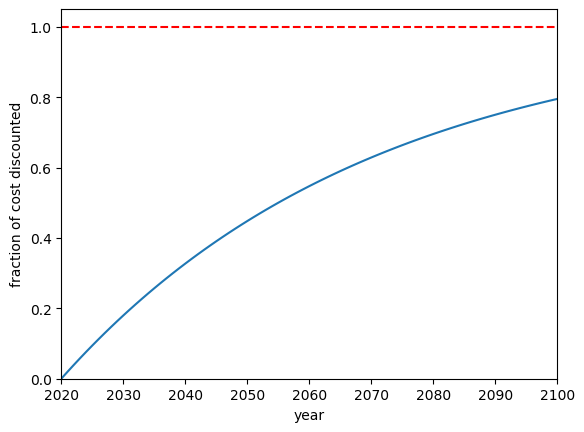

(0, 1.05)

In [137]:
discounting = (1. / (1. + ρ)).^(t.-t[1])
plot(t,1. .-discounting)
plot(t, ones(size(t)), "r--")
xlabel("year")
ylabel("fraction of cost discounted")
xlim(t[1],t[end])
ylim(0,1.05)

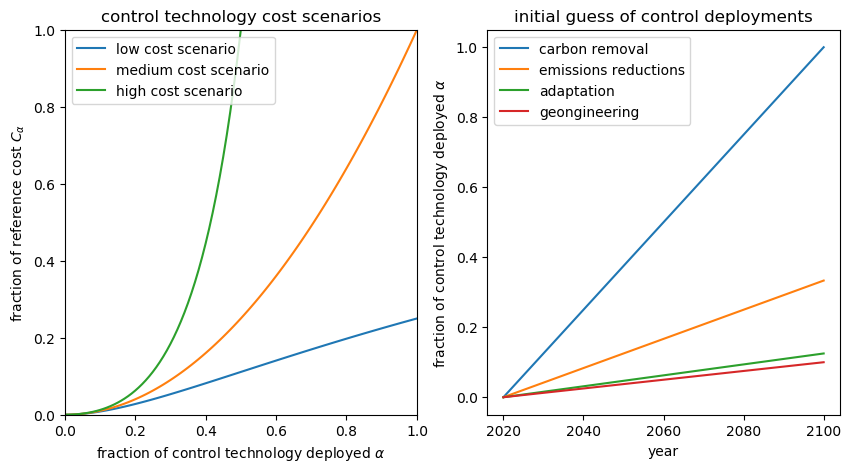

PyObject <matplotlib.legend.Legend object at 0x157614710>

In [138]:
x = 0:0.01:1.

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-x)).^2

figure(figsize=(10,5))
subplot(1,2,1)
plot(x,y_low, label="low cost scenario")
plot(x,y_med, label="medium cost scenario")
plot(x,y_high, label="high cost scenario")
xlim([0,1])
ylim([0,1])
title("control technology cost scenarios")
ylabel(L"fraction of reference cost $C_{\alpha}$")
xlabel(L"fraction of control technology deployed $\alpha$")
legend()

subplot(1,2,2)
plot(t, ϕ, label="carbon removal")
plot(t, φ, label="emissions reductions")
plot(t, λ, label="adaptation")
plot(t, χ, label="geongineering")
ylabel(L"fraction of control technology deployed $\alpha$")
xlabel("year")
title("initial guess of control deployments")
legend()

In [139]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_med(λ) .+ C_ϕ.*f_med(ϕ) .+ C_φ.*f_med(φ) .+ C_χ.*f_med(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

# Emissions, concentrations, warming, and cost trajectories for initial guess scenario

Assuming medium cost scenario $f_{\text{med}}(\alpha) = \alpha^{2}$.

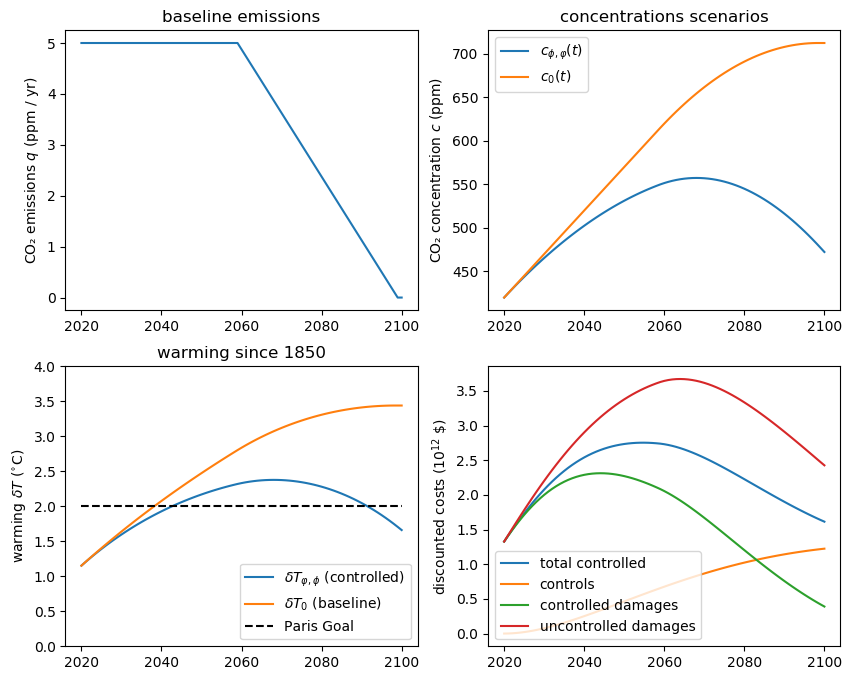

PyObject <matplotlib.legend.Legend object at 0x156f4cac8>

In [140]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, (C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ)) .* discounting, label="total controlled")
plot(t, C(ϕ, φ, χ, λ) .* discounting, label="controls")
plot(t, D(ϕ, φ, χ, λ) .* discounting, label="controlled damages")
plot(t, D_0 .* discounting, label="uncontrolled damages")
ylabel(L"discounted costs (10$^{12}$ \$)")
legend()

## Gradient descent cost minimization

In [141]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [142]:
count = 1
vprevious = [0., 0., 0., 0.]
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 5.e-4 # learning rate
    γ = 0.9 # momentum fraction
    v = [∇[1].*Δs .+ γ*vprevious[1],
         ∇[2].*Δs .+ γ*vprevious[2],
         ∇[3].*Δs .+ γ*vprevious[3],
         ∇[4].*Δs .+ γ*vprevious[4]]
    ϕ .-= v[1]
    φ .-= v[2]
    χ .-= v[3]
    λ .-= v[4]
    count+=1
    
    vprevious = copy(v)
    
    if count>1000
        break
    end
end

1903.1737927767551 1773.867819555046 1622.7526938890242 1485.9027037314227 1331.2186197310364 1159.2555598804763 997.5104879756784 850.589146597435 713.9883939783514 594.8347376171662 497.0752217876039 416.4907341587225 352.037381739347 304.1847383476883 269.3488767162428 244.2501313942814 227.77609385116418 217.57414219568363 210.88205609970038 206.5720093172986 203.61214480665413 200.5321002846266 196.75799101125995 192.19980450164866 186.4545682399183 179.43431788588234 171.47806900878146 162.7371280148509 153.3417283468794 143.66814168655992 133.99987508036742 124.47105783627596 115.3076026303957 106.70799384072981 98.7212178712149 91.40126205051864 84.81433598635334 78.93059577627197 73.6943085387908 69.07978228410002 65.02263209433582 61.43221803564969 58.24923139472451 55.41438248345758 52.851860573500986 50.50878087297286 48.34886961612323 46.328128325026285 44.41379663798196 42.59082113017209 40.842104676454255 39.15316293085615 37.52234047901181 35.94880556782498 34.428855885

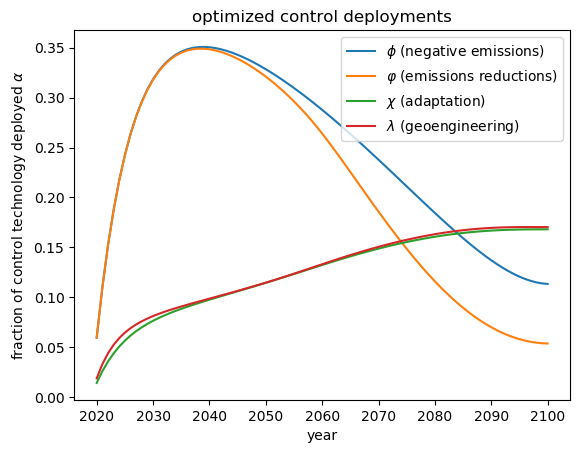

PyObject <matplotlib.legend.Legend object at 0x151ef3dd8>

In [145]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
ylabel(L"fraction of control technology deployed $\alpha$")
xlabel("year")
title("optimized control deployments")
legend()

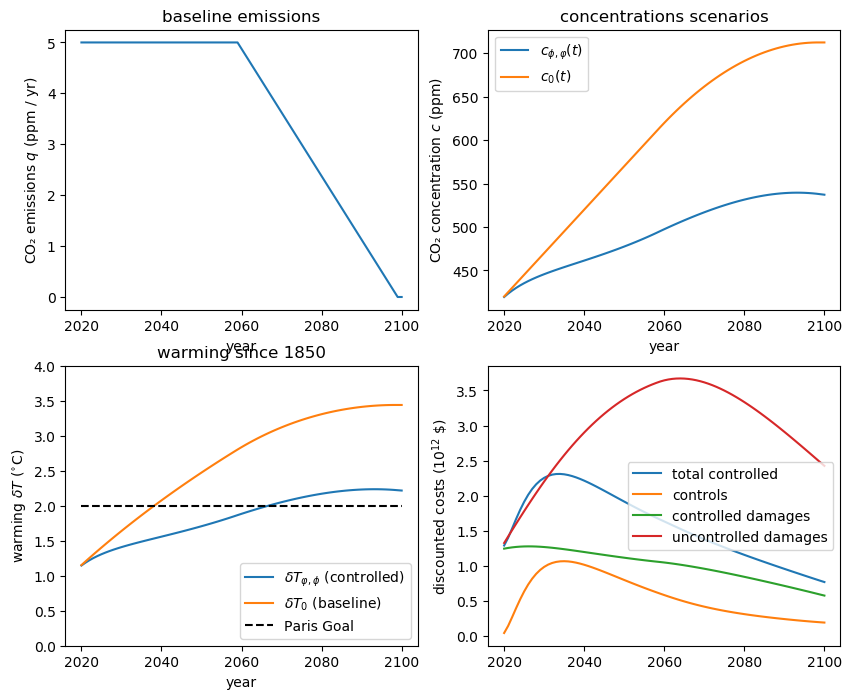

PyObject <matplotlib.legend.Legend object at 0x154f8cf28>

In [146]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
xlabel("year")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
xlabel("year")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
xlabel("year")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, (C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ)) .* discounting, label="total controlled")
plot(t, C(ϕ, φ, χ, λ) .* discounting, label="controls")
plot(t, D(ϕ, φ, χ, λ) .* discounting, label="controlled damages")
plot(t, D_0 .* discounting, label="uncontrolled damages")
ylabel(L"discounted costs (10$^{12}$ \$)")
legend()